In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random as rd


Bad key text.latex.preview in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\RoboDK\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an

In [3763]:
class Point3D():
    def __init__(self, array):
        self.x = array[0]
        self.y = array[1]
        self.z = array[2]
        self.coordinates = array
        return None

    def translation(self, vector):  # returns the 3D point located at current_point + vector
        coordinates = self.coordinates + vector.coordinates
        return Point3D(coordinates)

    # returns the 3D point corresponding to the homothety of the current point by a factor k
    def homothety(self, k):
        coordinates = k*self.coordinates
        return Point3D(coordinates)

    def add(self, point):
        coordinates = self.coordinates + point.coordinates
        return Point3D(coordinates)

    def Vector(self, point2):  # returns the 3D vector from current_point to point2
        coordinates = point2.coordinates - self.coordinates
        return EuclidianVector3D(coordinates)

    def toVector(self):  # returns the 3D vector associated with current_point
        return EuclidianVector3D(self.coordinates)



class EuclidianVector3D():
    def __init__(self, array):
        self.x = array[0]
        self.y = array[1]
        self.z = array[2]
        self.coordinates = array
        return None

    def translation(self, point):  # returns the 3D point located at point + current_vector
        coordinates = self.coordinates + point.coordinates
        return Point3D(coordinates)

    def add(self, vector):  # returns the vector consisting in the sum of the current and the given vectors
        coordinates = self.coordinates + vector.coordinates
        return EuclidianVector3D(coordinates)

    # returns the 3D vector corresponding to the homothety of the current vector by a factor k
    def homothety(self, k):
        coordinates = k*self.coordinates
        return EuclidianVector3D(coordinates)

    def normalize(self):
        norm = math.sqrt(self.x**2 + self.y**2 + self.z**2)
        return EuclidianVector3D(self.coordinates/norm)

    def toPoint(self):          # returns the 3D point associated with current_vector
        return Point3D(self.coordinates)

    # returns the 3D Vector representing the rotation of current_vector by an angle theta around the vector
    def rotate(self, vector, theta):
        c = math.cos(theta)
        s = math.sin(theta)

        u = vector.normalize()
        x = round((u.x**2*(1-c) + c) * self.x + (u.x*u.y*(1-c) - u.z*s) *
                  self.y + (u.x*u.z*(1-c) + u.y*s)*self.z, 10)
        y = round((u.x*u.y*(1-c) + u.z*s) * self.x + (u.y**2*(1-c) + c) *
                  self.y + (u.y*u.z*(1-c) - u.x*s)*self.z, 10)
        z = round((u.x*u.z*(1-c) - u.y*s) * self.x +
                  (u.y*u.z*(1-c) + u.x*s) * self.y + (u.z**2*(1-c) + c)*self.z, 10)
        return EuclidianVector3D(np.array(x, y, z))


In [3764]:
class Sequence():
    def __init__(self, array=np.array([])):
        self.samples = array

    def map(self, f):
        return Sequence([f(sample) for sample in self.samples])

    def reduce(self, f):
        result = self.samples[0]
        for i in range(1, len(self.samples)):
            result = f(result, self.samples[i])
        return result

In [3765]:
# computes the deformation field as a sequence of vectors based on the two given shapes
def Deformation(shape1, shape2):
    vectors = []  # the shapes are sequences of points in which each id corresponds to the same point in the correspondance
    for id in range(len(shape1.samples)):
        vectors.append(shape1.samples[id].Vector(shape2.samples[id]))
    return Sequence(vectors)

In [3766]:
def meanshape(seq):  # computes the mean shape of the given sequence of shapes

    def sum(seq1, seq2):
        list = []
        for i in range(len(seq1.samples)):
            list.append(seq1.samples[i].add(seq2.samples[i]))
        return Sequence(np.array(list))

    n = len(seq.samples)

    new_seq = seq.reduce(sum).map(lambda x: x.homothety(1/n))

    return new_seq

In [3767]:
def covariance_matrix(seq):
    
    vector_list = []
    for vector in seq.samples[0].samples:
        vector_list += list(vector.coordinates)
        
    tot_vector = np.array([vector_list])
    Matrix = np.matmul(np.transpose(tot_vector), tot_vector)

    for deformation_field in range(1,len(seq.samples)):
        vector_list = []
        for vector in seq.samples[deformation_field].samples:
            vector_list+= list(vector.coordinates)
        
        tot_vector = np.array([vector_list])
        Matrix += np.matmul(np.transpose(tot_vector), tot_vector)
    
    return Matrix/(len(seq.samples) - 1)

def covariance_matrix_restriction(seq1,seq2):
    vector1_list = []
    vector2_list = []
    for vector in seq1.samples[0].samples:
        vector1_list += list(vector.coordinates)
    for vector in seq2.samples[0].samples:
        vector2_list += list(vector.coordinates)
    
    vector1 = np.array([vector1_list])
    vector2 = np.array([vector2_list])
    Matrix = np.matmul(np.transpose(vector2),vector1)

    for deformation_field in range(1,len(seq1.samples)):
        vector1_list = []
        vector2_list = []
        for vector in seq1.samples[deformation_field].samples:
            vector1_list += list(vector.coordinates)
        for vector in seq2.samples[deformation_field].samples:
            vector2_list += list(vector.coordinates)
        
        vector1 = np.array([vector1_list])
        vector2 = np.array([vector2_list])
        Matrix += np.matmul(np.transpose(vector2),vector1)

    return Matrix/(len(seq1.samples)-1)

In [3768]:
def norm(array):
    return math.sqrt(array[0]**2+array[1]**2+array[2]**2)


def covariance_function(x1, x2, seq):
    matrix = np.matmul(np.transpose(np.array([list(seq.samples[0].samples[x2].coordinates)])), np.array(
        [list(seq.samples[0].samples[x1].coordinates)]))

    for i in range(1, len(seq.samples)):
        matrix += np.matmul(np.transpose(np.array([list(seq.samples[i].samples[x2].coordinates)])), np.array(
            [list(seq.samples[i].samples[x1].coordinates)]))

    return matrix/len(seq.samples)

def gaussian_kernel(point1,point2,sigma_list = [1,1,1],s_list = [0.01,0.01,0.01]):
    return np.matrix([[s_list[0]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[0]),0,0],[0,s_list[1]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[1]),0],[0,0,s_list[2]*math.exp(-norm(point1.coordinates - point2.coordinates)/sigma_list[2])]])


In [3769]:
def posterior_meanshape(seq, seq_observations, meanshape ,utilde, sigma2_measure = 0):
    
    observation_cov_matrix = covariance_matrix(seq_observations)
    constant_matrix = np.matmul(utilde,np.linalg.inv(observation_cov_matrix + sigma2_measure*np.eye(len(observation_cov_matrix))))
    list_mean = []
    for point_id in range(len(seq.samples[0].samples)):
        KxY = covariance_matrix_restriction(Sequence(np.array([Sequence(np.array([seq.samples[i].samples[point_id]])) for i in range(len(seq.samples))])),seq_observations)
        list_mean.append(Point3D(np.array((meanshape.samples[point_id].coordinates + np.matmul(constant_matrix,KxY))[0])))
    
    return Sequence(np.array(list_mean))
    
def posterior_covariance_function(x1,x2,pms, seq, seq_observations, sigma_list, s_list, sigma2_measure = 0):

    observation_cov_matrix = covariance_matrix(seq_observations)
    constant_matrix = np.linalg.inv(observation_cov_matrix + sigma2_measure*np.eye(len(observation_cov_matrix)))
    return gaussian_kernel(pms.samples[x1],pms.samples[x2],sigma_list,s_list) - np.matmul(covariance_matrix_restriction(seq_observations,Sequence(np.array([Sequence(np.array([seq.samples[i].samples[x2]])) for i in range(len(seq.samples))]))),np.matmul(constant_matrix,covariance_matrix_restriction(Sequence(np.array([Sequence(np.array([seq.samples[i].samples[x1]])) for i in range(len(seq.samples))])),seq_observations)))
    #return gaussian_kernel(pms.samples[x1],pms.samples[x2],sigma_list,s_list)

def reorganisation(meanshape, seq,  obs_dict):

    X_index = []
    Y_index = []
    utilde = []
    for i in range(len(meanshape.samples)):
        if i in obs_dict:
            Y_index.append(i)
            utilde += list(obs_dict[i])
        else:
            X_index.append(i)
    
    utilde = np.array([utilde])
    restriction_Y = Sequence(np.array([Sequence(np.array([seq.samples[i].samples[j] for j in Y_index])) for i in range(len(seq.samples))]))
    return restriction_Y, utilde

In [3770]:
shape_list = []
randomness = 0.01
for i in range(50):
    random_value1 = rd.random()
    random_value2 = rd.random()
    random_value3 = rd.random()
    point1 = Point3D(np.array([1 + 0.3*(random_value1-0.5) + randomness*(rd.random() - 0.5), 0 + 0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5), 0 + 0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    point2 = Point3D(np.array([0 + 0.3*(random_value1-0.5)+ randomness*(rd.random() - 0.5), 1 + 0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5), 0 + 0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    point3 = Point3D(np.array([-1 + 0.3*(random_value1-0.5)+ randomness*(rd.random() - 0.5), 0 + 0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5), 0 + 0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    point4 = Point3D(np.array([0 + 0.3*(random_value1-0.5)+ randomness*(rd.random() - 0.5), -1 + 0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5), 0 + 0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    point5 = Point3D(np.array([0.3*(random_value1-0.5)+ randomness*(rd.random() - 0.5),0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5),0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    point6 = Point3D(np.array([0.5 + 0.3*(random_value1-0.5)+ randomness*(rd.random() - 0.5), -0.5 + 0.3*(random_value2-0.5)+ randomness*(rd.random() - 0.5),1+ 0.3*(random_value3-0.5)+ randomness*(rd.random() - 0.5)]))
    shape_list.append(Sequence(np.array([point1,point2,point3,point4,point5,point6])))

shapes = Sequence(np.array(shape_list))


In [3771]:
random_value1 = 2*rd.random() - 1
random_value2 = 2*rd.random() - 1
random_value3 = 2*rd.random() - 1

#obs_dict = {0:[random_value1 + 0.1*(rd.random() - 0.5) ,random_value2 + 0.1*(rd.random() - 0.5),random_value3 + 0.1*(rd.random() - 0.5)],1:[random_value1+ 0.1*(rd.random() - 0.5),random_value2+ 0.1*(rd.random() - 0.5) ,random_value3+ 0.1*(rd.random() - 0.5)], 2:[random_value1+ 0.1*(rd.random() - 0.5),random_value2+ 0.1*(rd.random() - 0.5),random_value3+ 0.1*(rd.random() - 0.5)]}
obs_dict = {0:[random_value1 + randomness*(rd.random() - 0.5) ,random_value2 + randomness*(rd.random() - 0.5),random_value3 + randomness*(rd.random() - 0.5)],1:[random_value1+ randomness*(rd.random() - 0.5),random_value2+ randomness*(rd.random() - 0.5) ,random_value3+ randomness*(rd.random() - 0.5)]}
#obs_dict = {0:[random_value1 + 0.1*(rd.random() - 0.5) ,random_value2 + 0.1*(rd.random() - 0.5),random_value3 + 0.1*(rd.random() - 0.5)]}

sigma_list = [randomness**2/12,randomness**2/12,randomness**2/12]
s_list = [0.001,0.001,0.001]

ms = meanshape(shapes)
Seq = Sequence(np.array([Deformation(ms, shape) for shape in shapes.samples]))


Y, utilde = reorganisation(ms,Seq, obs_dict)
pms = posterior_meanshape(Seq, Y, ms, utilde)

In [3772]:
print(covariance_function(0,0,Seq))
print(posterior_covariance_function(0,0,pms,Seq,Y, sigma_list, s_list))

[[ 0.00682567 -0.0007046   0.00084128]
 [-0.0007046   0.00890168 -0.00035469]
 [ 0.00084128 -0.00035469  0.00564074]]
[[-0.00596497  0.00071898 -0.00085845]
 [ 0.00071898 -0.00808335  0.00036193]
 [-0.00085845  0.00036193 -0.00475586]]


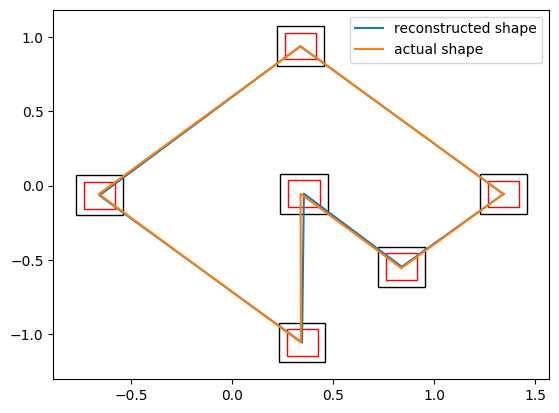

In [3773]:
liste_X = []
liste_Y = []

fig, ax = plt.subplots()

for k in range(len(pms.samples)):
    i = pms.samples[k]
    M = posterior_covariance_function(k,k,pms,Seq,Y, sigma_list, s_list)
    liste_X.append(i.coordinates[0])
    liste_Y.append(i.coordinates[1])
    ax.add_patch(Rectangle((i.coordinates[0]-1.5*np.sqrt(abs(M[0,0])),i.coordinates[1]-1.5*np.sqrt(abs(M[1,1]))),3*math.sqrt(abs(M[0,0])),3*math.sqrt(abs(M[1,1])), fill = False))      #confiance à 99.73%
    ax.add_patch(Rectangle((i.coordinates[0]-np.sqrt(abs(M[0,0])),i.coordinates[1]-np.sqrt(abs(M[1,1]))),2*math.sqrt(abs(M[0,0])),2*math.sqrt(abs(M[1,1])), fill = False,color = "r"))  #confiance à 95.45%

liste_X.append(liste_X[0])
liste_Y.append(liste_Y[0])
plt.plot(liste_X,liste_Y, label = "reconstructed shape")

liste_X = []
liste_Y = []
for i in obs_dict:
    liste_X.append(ms.samples[i].coordinates[0] + obs_dict[i][0])
    liste_Y.append(ms.samples[i].coordinates[1] + obs_dict[i][1])

for i in range(len(ms.samples)-len(obs_dict)):
    liste_X.append(ms.samples[len(obs_dict) +i].coordinates[0] + random_value1)
    liste_Y.append(ms.samples[len(obs_dict) +i].coordinates[1] + random_value2)

liste_X.append(liste_X[0])
liste_Y.append(liste_Y[0])
plt.plot(liste_X,liste_Y, label = "actual shape")
plt.legend()

plt.show()